Παραλίκας Ηλίας el16605

Ιωάννης Φαρδέλας el13190



Ανάλυση και Σχεδιασμός Πληροφοριακών Συστημάτων

Εργαδία D4c


#imports

In [85]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
!pip install sparkmeasure

openjdk-8-jdk-headless is already the newest version (8u382-ga-1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [86]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
import re
import math
import random
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.cm as cm

import matplotlib.pyplot as plt
%matplotlib inline
from pyspark import SparkConf
import pyspark.sql  as pyspark_sql
from sparkmeasure import StageMetrics
from pyspark.ml import Pipeline
from pyspark.ml.feature import  StringIndexer, VectorIndexer,VectorAssembler,StandardScaler, PCA
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.fpm import FPGrowth
from pyspark.sql import functions as F
from tensorflow import keras
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler as Scaler

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#SPARK

In [87]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

conf = SparkConf().set("spark.ui.port", "4050")


# create the context
# sc = pyspark.SparkContext(conf=conf)
# spark = pyspark_sql.SparkSession.builder.getOrCreate()
spark = pyspark_sql.SparkSession \
 .builder \
 .master("local[*]") \
 .appName("Test sparkmeasure instrumentation of Python/PySpark code") \
 .config("spark.jars.packages","ch.cern.sparkmeasure:spark-measure_2.12:0.22")  \
 .getOrCreate()


stagemetrics = StageMetrics(spark)

spark

#Data Generators

##Categorical Data Generator

In [88]:
def categorical_data_generator(num,dimensions_list,batch=1):
  i= 0
  while(i<num):
    final_batch = np.zeros(sum(dimensions_list),dtype=np.int32)
    final_batch = np.array([final_batch])

    for batch_counter in range(batch):
      row =np.array([],dtype=np.int32)
      for features in dimensions_list:
        selected = random.randrange(0, features)
        y  = np.zeros(features,dtype=np.int32)
        y[selected]  = 1
        row = np.concatenate((row , y),axis=None)
      row = np.array([row])
      final_batch = np.concatenate((final_batch,row),axis = 0)
    yield final_batch[1:]
    i = i+1
  while True:
    yield False


In [89]:
gen = categorical_data_generator(200,[8],10)
cat=next(gen)

In [90]:
cat

array([[0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

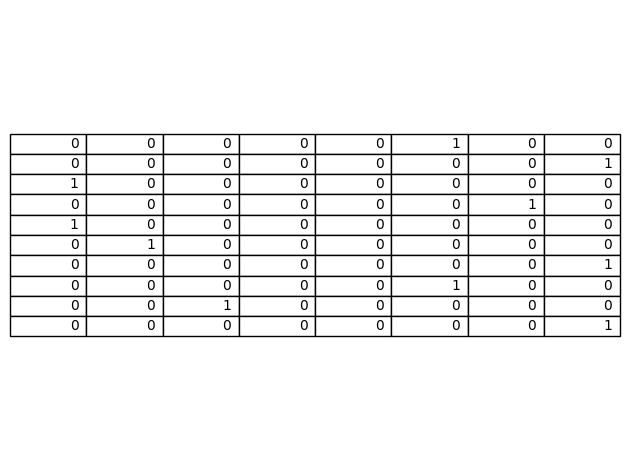

In [91]:

fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
ax.table(cellText=cat, loc='center')

fig.tight_layout()

plt.show()

##Circle Data Generator

In [92]:
def circle_data_generator(num,dimensions,radius,deviation,batch=-1,offset = []):
  if batch ==-1:
    batch = num
  if offset:
    assert len(offset) == dimensions
    offset = np.array(offset)
  else:
    offset = np.zeros(dimensions)
  i= 0
  while(i<num):
    final_batch = np.zeros(dimensions,dtype=np.int32)
    final_batch = np.array([final_batch])

    for batch_counter in range(batch):
      total_radius =radius + random.randrange(-deviation, deviation)
      row  = np.array([],dtype=np.int32)
      for d in range(dimensions-1):
        if total_radius >0:
          x = random.randrange(-total_radius, total_radius)
          total_radius = math.floor(math.sqrt((total_radius**2)-(x**2)))
        else:
          x= random.randrange(1, 10)
        row = np.append(row,x)


      x = random.randrange(-1,2,2)*total_radius
      row = np.append(row,x)

      random.shuffle(row)
      row = np.array([row])
      row = np.add(row,offset)
      final_batch = np.concatenate((final_batch,row),axis = 0)

    yield final_batch[1:]
    i = i+1
  while True:
    yield False

###2D

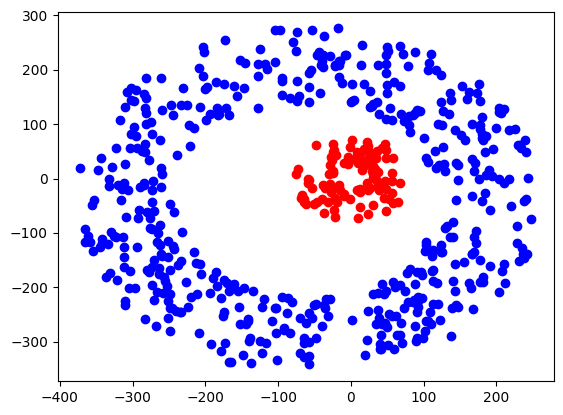

In [93]:
gen = circle_data_generator(100,2,50,30)
y1=next(gen)
gen = circle_data_generator(500,2,250,70,offset =[-60,-40])
y2=next(gen)
f, ax = plt.subplots(1)
ax.scatter(*zip(*y1),color='r')
ax.scatter(*zip(*y2),color='b')

###3D

In [94]:
gen = circle_data_generator(200,3,700,30,200)
y1_3d= next(gen)

In [95]:
gen = circle_data_generator(200,3,200,70,200,offset=[120,130,160])
y2_3d=next(gen)

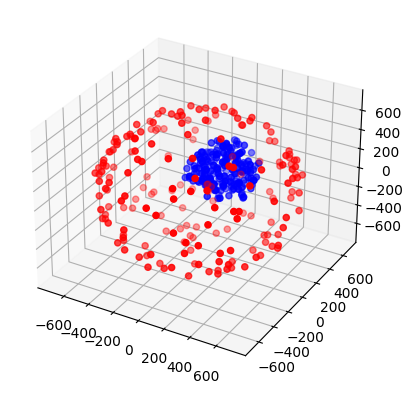

In [96]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*zip(*y1_3d),color='r')
ax.scatter(*zip(*y2_3d),color='b')

##Dataset Builder

In [97]:
class class_characteristics:
  def __init__(self,num,circle_dimensions,range,deviation,class_num,cat_dimensions_list,offset=[]):
        self.num = num
        self.circle_dimensions=circle_dimensions
        self.range=range
        self.deviation=deviation
        self.class_num=class_num
        self.cat_dimensions_list=cat_dimensions_list
        self.offset=offset

In [98]:
def create_class(class_char):
  circle_gen = circle_data_generator(class_char.num,class_char.circle_dimensions,class_char.range,class_char.deviation,class_char.num,class_char.offset)
  circle_features = next(circle_gen)

  categorical_gen =categorical_data_generator(class_char.num,class_char.cat_dimensions_list,class_char.num)
  categorical_features = next(categorical_gen)

  cat_dimensions = sum(class_char.cat_dimensions_list)

  class_features = np.full((class_char.num,class_char.circle_dimensions+cat_dimensions+1),class_char.class_num,dtype=np.int32)


  features = np.concatenate((circle_features,categorical_features),axis=1)

  class_features[:,:-1] = features

  return pd.DataFrame(data = class_features)


In [99]:
class_0_char = class_characteristics(10,7,30,8,0,[4,2])
class_0 = create_class(class_0_char)
print(class_0)

   0   1   2   3   4   5   6   7   8   9   10  11  12  13
0   1   2  12  -1  -6  11  27   0   1   0   0   1   0   0
1  -3 -10   8   3  14   5 -27   1   0   0   0   1   0   0
2 -11   1  -3   1   0 -16 -14   0   0   1   0   1   0   0
3 -17  -2  -3   6  16   5   2   1   0   0   0   0   1   0
4 -26   0   5  -8   1   2  -3   0   0   1   0   0   1   0
5 -14   1  -2   4   0  19  -3   0   0   1   0   1   0   0
6  24  -5 -10  -5  -7   4  16   0   1   0   0   0   1   0
7   7 -20   0  -3  12  -5   3   0   1   0   0   1   0   0
8  -1   3  30   2   6   4   2   0   0   0   1   1   0   0
9   6  -3   5  24   0   8   5   0   0   0   1   0   1   0


In [100]:
def dataset_builder(class_population,circle_dim,range_list,deviation_list,cat_dim_list,class_start = 0):
  characteristics_list =[]
  for i,num in enumerate(class_population):
    class_c =class_characteristics(num,circle_dim,range_list[i],deviation_list[i],class_start+i,cat_dim_list)
    characteristics_list.append(class_c)


  dataset = pd.DataFrame()
  for class_char in characteristics_list:
    class_ = create_class(class_char)
    dataset= dataset.append(class_)
  dataset_path ='gdrive/MyDrive/D4c/dataset_class_'+str(class_start)+'.csv'
  dataset.to_csv(dataset_path,header=None,mode='w')



###Create dataset


In [101]:
create_dataset = False
if create_dataset:
  class_counter_path = "gdrive/MyDrive/D4c/class_counter.txt"
  if not os.path.isfile(class_counter_path):
    f = open(class_counter_path, "w")
    f.write(str(0))
    f.close()
  number_of_numerical_data=100
  categorical_data_dim =[2,2,3,4,5,6,7,8,9,10]
  radius_max = int(1e6)
  radius_min =int(1e3)
  deviation_max = int(1e2 -1 )
  deviation_min = 10
  population_max  =  int(1e6)
  population_min  =  int(1e5)

  while True:
    f = open(class_counter_path, "r")
    c = int(f.read())
    dataset_path ='gdrive/MyDrive/D4c/dataset_class_'+str(c)+'.csv'

    population = random.randint(population_min, population_max)
    radius = random.randint(radius_min, radius_max)
    deviation = random.randint(deviation_min,deviation_max)
    dataset_builder([population],number_of_numerical_data,[radius],[deviation],categorical_data_dim,c)
    print(c)
    c = c +1
    f = open(class_counter_path, "w")
    f.write(str(c))
    f.close()


###Read Dataset

In [102]:
def read_dataset_paths(dataset_repetition,number_of_classes,dataset_folder):
  dataset_paths  = []
  unique_dataset_paths =[]
  for filename in os.listdir(dataset_folder):
    unique_dataset_paths.append(dataset_folder +'/'+filename)
  if len(unique_dataset_paths) > number_of_classes:
    unique_dataset_paths = unique_dataset_paths[:number_of_classes]

  for i in range(dataset_repetition):
    dataset_paths.extend(unique_dataset_paths)

  return dataset_paths

In [103]:
def get_dataset(number_of_classes,dataset_size,verical_cut,classes_directory ='gdrive/MyDrive/D4c/classes',dataset_repetition=1):
  dataset_folder = classes_directory + '/'+dataset_size
  dataset_paths = read_dataset_paths(dataset_repetition,number_of_classes,dataset_folder)
  sparkDF=spark.read.csv(dataset_paths,inferSchema =True)
  total_rows = sparkDF.count()

  if verical_cut =='small':
    drop_num_colums =random.randrange(70, 90)
    drop_cat_cols  = random.randrange(40, 56)
  else:
    if verical_cut =='medium':
      drop_num_colums =random.randrange(50, 70)
      drop_cat_cols  = random.randrange(20, 40)
    else:
      if verical_cut == 'big':
        drop_num_colums =random.randrange(0, 50)
        drop_cat_cols  = random.randrange(0,20)
      else:
        print("please specify small-medium-big verical_cut as parameter")
        return
  columns = []
  for i in range(drop_num_colums):
    c = '_c' +str(i)
    columns.append(c)
  for i in range(drop_cat_cols):
    c = '_c' +str(100+i)
    columns.append(c)
  sparkDF = sparkDF.drop(*columns)
  return sparkDF,total_rows,drop_num_colums,drop_cat_cols

##FP Growth Data Generation


In [104]:
def FP_Growth_data_generator(FP_Growth_data_counter_file,rows=10,total_items=1000,max_list_len = 30,min_list_len = 1):
  f = open(FP_Growth_data_counter_file, "r")
  FP_Growth_data_counter = int(f.read())
  f.close()
  df = pd.DataFrame(columns=['items'])
  for i in range(rows):
    len  = random.randint(min_list_len, max_list_len)
    items =random.sample(range(0, total_items), len)
    df = df.append({'items':items}, ignore_index=True)

  filepath = Path(FP_Growth_directory+'/data_folder/data_'+str(FP_Growth_data_counter)+'.csv')
  filepath.parent.mkdir(parents=True, exist_ok=True)
  df.to_csv(filepath)

  f = open(FP_Growth_data_counter_file, "w")
  FP_Growth_data_counter  = FP_Growth_data_counter+1
  f.write(str(FP_Growth_data_counter))
  f.close()


In [105]:
create_fp_data = False
if create_fp_data:
  while True:
    FP_Growth_data_generator(rows=1000000)


#Excecutors

##Decision Tere

###Decision Tree Builder

In [22]:
def Decision_tree_builder(sparkDF,analyse=False):
  assem = VectorAssembler(inputCols=sparkDF.columns, outputCol='features')
  data  = assem.transform(sparkDF)
  labelIndexer = StringIndexer(inputCol=sparkDF.columns[-1], outputCol="indexedLabel").fit(data)
  featureIndexer =\
      VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(data)

  (trainingData, testData) = data.randomSplit([0.99, 0.01])

  # Train a DecisionTree model.
  dt = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")

  # Chain indexers and tree in a Pipeline
  pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dt])
  # Train model.  This also runs the indexers.
  pipeline.fit(trainingData)

  model = pipeline.fit(trainingData)



  # Make predictions.

  predictions = model.transform(testData)

  if(analyse):
      # Select example rows to display.
    predictions.select("prediction", "indexedLabel", "features").show(10)
    # Select (prediction, true label) and compute test error
    evaluator = MulticlassClassificationEvaluator(
        labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    print("Test Error = %g " % (1.0 - accuracy))
    print("Acc = %g " % (accuracy))
    treeModel = model.stages[2]
    # summary only
    print(
        treeModel)

  return predictions

###DecisionTree Trials

In [23]:
Decision_tree_results_directory = 'gdrive/MyDrive/D4c/decision_tree_results'
Decision_tree_trial_counter = Decision_tree_results_directory +'/trial_counter.txt'

In [24]:
if not os.path.isfile(Decision_tree_trial_counter):
  f = open(Decision_tree_trial_counter, "w")
  f.write(str(0))
  f.close()


In [25]:
%%capture cap
number_of_classes =3
dataset_size = "small"
verical_cut = 'small'
sparkDF,total_rows,drop_num_colums,drop_cat_cols = get_dataset(number_of_classes,dataset_size,verical_cut)
print('&#number_of_classes:'+str(number_of_classes)+'#total_rows:'+str(total_rows)+'#numerical_data_dim:'+str(100 - drop_num_colums)+'#total_cat_data_dim:'+str(56-drop_cat_cols))
command  = "Decision_tree_builder(sparkDF)"
stagemetrics.runandmeasure(globals(),command)

In [26]:
f = open(Decision_tree_trial_counter, "r")
trial = int(f.read())
f.close()

f = open(Decision_tree_results_directory +'/trials/trial_'+str(trial)+'.txt', "w")
print(cap, file=f)
f.close()
trial = trial+1
f = open(Decision_tree_trial_counter, "w")
f.write(str(trial))
f.close()

##PCA

###PCA Trials

In [27]:
pca_results_directory = 'gdrive/MyDrive/D4c/pca_results'
pca_results_trial_counter = pca_results_directory +'/trial_counter.txt'

In [28]:
if not os.path.isfile(pca_results_trial_counter):
  f = open(pca_results_trial_counter, "w")
  f.write(str(0))
  f.close()


In [29]:
%%capture cap
number_of_classes =2
n_components =2
dataset_repetition = 1
dataset_size = "small"
verical_cut = 'small'
sparkDF,total_rows,drop_num_colums,drop_cat_cols = get_dataset(number_of_classes,dataset_size,verical_cut,dataset_repetition=dataset_repetition)
print('&#number_of_classes:'+str(number_of_classes)+'#total_rows:'+str(total_rows)+'#numerical_data_dim:'+str(100 - drop_num_colums)+'#total_cat_data_dim:'+str(56-drop_cat_cols)+"#n_components:"+str(n_components))
assembler = VectorAssembler(inputCols = sparkDF.columns, outputCol = 'features')
df = assembler.transform(sparkDF).select('features')
scaler = StandardScaler(inputCol = 'features', outputCol = 'scaledFeatures').fit(df)
df_scaled = scaler.transform(df)
command = "PCA(k =n_components, inputCol = 'scaledFeatures', outputCol = 'pcaFeatures').fit(df_scaled)"
stagemetrics.runandmeasure(globals(),command)

In [30]:
f = open(pca_results_trial_counter, "r")
trial = int(f.read())
f.close()
#
f = open(pca_results_directory +'/trials/trial_'+str(trial)+'.txt', "w")
print(cap, file=f)
f.close()
trial = trial+1
f = open(pca_results_trial_counter, "w")
f.write(str(trial))
f.close()

##FP Growth

### FP Growth Read Dataset

In [31]:
def read_fp_dataset_paths(dataset_repetition,number_of_classes,dataset_folder):
  dataset_paths  = []
  unique_dataset_paths =[]
  total_rows = 0
  mean_item_sum = 0
  for filename in os.listdir(dataset_folder):
    unique_dataset_paths.append(dataset_folder +'/'+filename)
  if len(unique_dataset_paths) > number_of_classes:
    unique_dataset_paths = unique_dataset_paths[:number_of_classes]

  for i in range(dataset_repetition):
    dataset_paths.extend(unique_dataset_paths)

  for filename in dataset_paths:
    info = filename.split('_')
    max_items_per_list = info[-2][:-4]
    rows = info[-1][:-4]
    total_rows += int(rows)
    mean_item_sum += int(rows) * (int(max_items_per_list) /2)

  mean_item = mean_item_sum /total_rows

  return dataset_paths, mean_item,total_rows

In [32]:
def excecute_FP_Growth(sparkDF,minSupport=0.6, minConfidence=0.6):

  fpGrowth = FPGrowth(itemsCol="items", minSupport=minSupport, minConfidence=minConfidence)
  fpGrowth.fit(sparkDF)

###FP Growth Trials

In [33]:
fp_growth_directory = 'gdrive/MyDrive/D4c/FP_Growth'
fp_growth_results_directory = fp_growth_directory + '/fp_growth_results'
fp_growth_results_trial_counter = fp_growth_results_directory +'/trial_counter.txt'

In [34]:
if not os.path.isfile(fp_growth_results_trial_counter):
  f = open(fp_growth_results_trial_counter, "w")
  f.write(str(0))
  f.close()

In [35]:
%%capture cap
number_of_files =1
dataset_repetition =1
minSupport=0.4
minConfidence=0.6
number_of_classes = int(number_of_files)
classes_directory ='gdrive/MyDrive/D4c/fp_data'
dataset_paths, mean_item,total_rows = read_fp_dataset_paths(dataset_repetition,number_of_files,classes_directory)

sparkDF=spark.read.csv(dataset_paths,inferSchema = True,header='true', sep = '&')

sparkDF = sparkDF.withColumn(
    "items",
    F.from_json(F.col("items"), "array<integer>")
)


print('#total_rows:'+str(total_rows) +'#mean_item:'+str(mean_item)+"#minSupport:"+str(minSupport)+"#minConfidence:"+str(minConfidence))
command  = "excecute_FP_Growth(sparkDF,minSupport="+str(minSupport)+",minConfidence="+str(minConfidence)+")"
stagemetrics.runandmeasure(globals(),command)

In [36]:
f = open(fp_growth_results_trial_counter, "r")
trial = int(f.read())
f.close()

f = open(fp_growth_results_directory +'/trials/trial_'+str(trial)+'.txt', "w")
print(cap, file=f)
f.close()
trial = trial+1
f = open(fp_growth_results_trial_counter, "w")
f.write(str(trial))
f.close()

#Runtime Predictions

##Decode trial

In [37]:
EPOCHS =1000

In [107]:
def decode_trial(folder,
                output_names =['elapsedTime','executorRunTime','executorCpuTime','resultSize','diskBytesSpilled','memoryBytesSpilled','peakExecutionMemory','bytesRead']
):
  X =[]
  y =[]
  for trial_file in os.listdir(folder):
    file = open(folder+'/'+trial_file,mode='r')
    trials = file.read()
    trials = trials.split('&')[1:]
    for trial in trials:
      lines = trial.split('\n')
      inputs=  []
      outputs = []

      for line in lines:
        if len(line)>0:
          if line[0] =='#':
            orismata = line.split('#')
            for i in orismata:
              j = re.sub("[^0-9]", "",i)
              if j != '':
                inputs.append(float(j))

          for name in output_names:
            if line[:len(name)] ==name:
              value = line.split(' ')[2]
              outputs.append(int(value))
      X.append(inputs)
      y.append(outputs)
  return X,y

##Data augmentation

In [106]:
def augment_data(X,y,
  percetange =5,
  new_elements = 3000):

  X_elements = len(X)
  for i in range(new_elements):
    item = random.randint(0,X_elements)
    X_new = [element * (1 + random.random()*(percetange/100))for element in X[item]]
    y_new = [element * (1 + random.random()*(percetange/100)) for element in y[item]]
    X = np.append(X,[X_new],axis=0)
    y = np.append(y,[y_new],axis=0)
  return X,y

##Decision Tree Prediction

In [40]:
Decision_tree_trials_directory = Decision_tree_results_directory +'/trials'

### Data preprocessing

In [41]:
X,y = decode_trial(Decision_tree_trials_directory)
scalerX = Scaler()
scalerY = Scaler()
scalerX.fit(X)
scalerY.fit(y)

X = scalerX.transform(X)
y=  scalerY.transform(y)
X_min = X.min()
X = X -X_min
y_min= y.min()
y= y - y_min

###Correlation

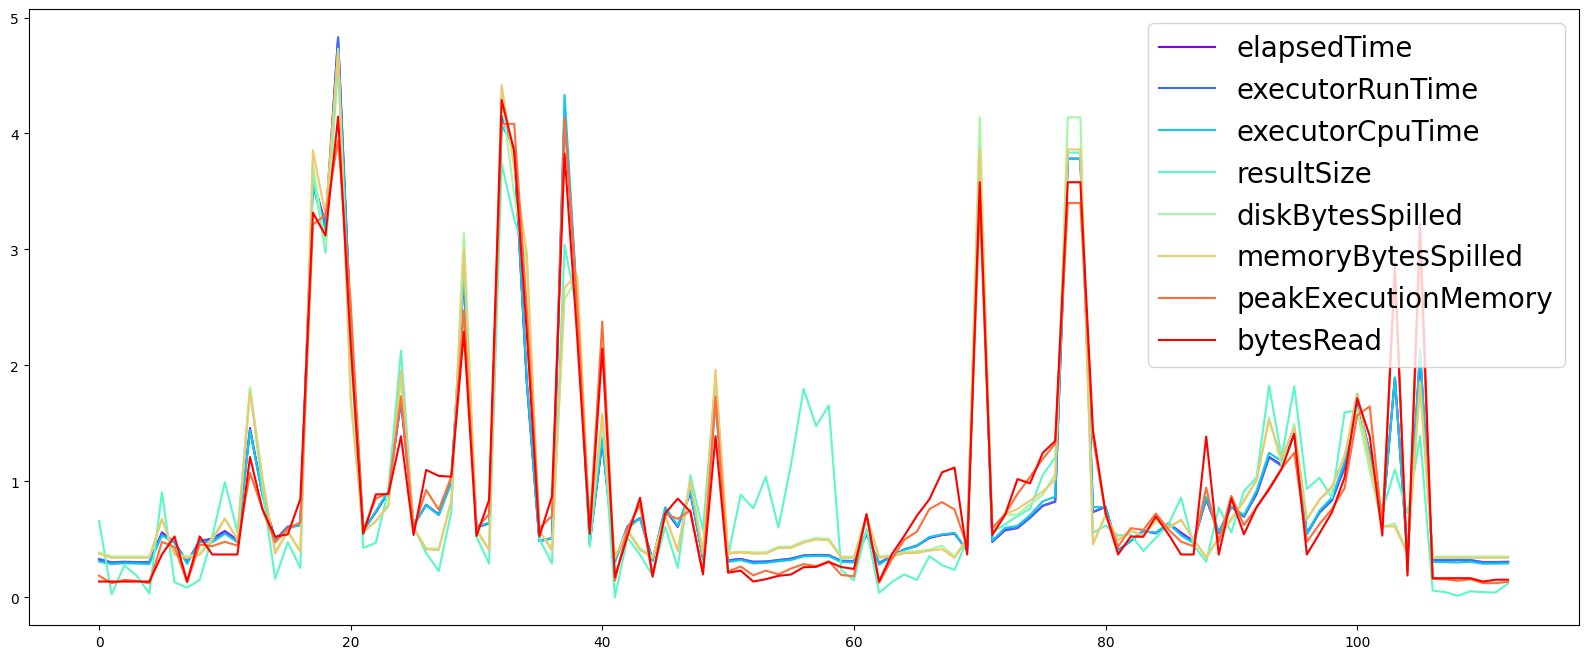

In [42]:
x_select =1
X_names =['number of classes','numbers of rows','numerical data dimensions','categorical data dimensions']
y_names =['elapsedTime','executorRunTime','executorCpuTime','resultSize','diskBytesSpilled','memoryBytesSpilled','peakExecutionMemory','bytesRead']
colors = cm.rainbow(np.linspace(0, 1, len(y_names)))
plt.figure(figsize=(20,8))

for y_select in range(len(y_names)):
  y_0 = [first[y_select] for first in y]
  plt.plot(y_0,c=colors[y_select],label =y_names[y_select])

plt.legend(loc="upper right",prop={'size': 20})

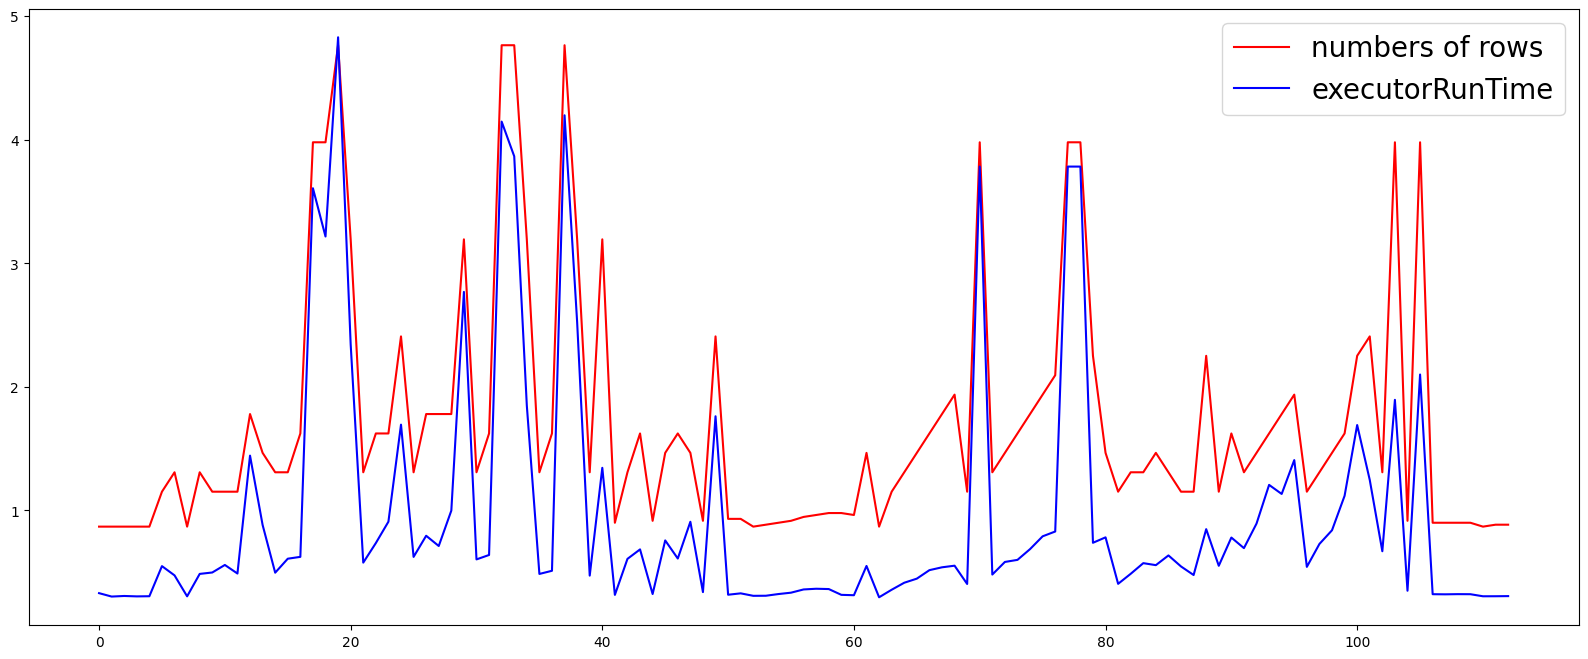

In [43]:
x_select= 1
y_select = 1
X_names =['number of classes','numbers of rows','numerical data dimensions','categorical data dimensions']
y_names =['elapsedTime','executorRunTime','executorCpuTime','resultSize','diskBytesSpilled','memoryBytesSpilled','peakExecutionMemory','bytesRead']

X_size = [x[x_select] for x in X]
plt.figure(figsize=(20,8))
plt.plot(X_size,c='r',label  =X_names[x_select] )
y_0 = [first[y_select] for first in y]
plt.plot(y_0,c='b',label =y_names[y_select])
plt.legend(loc="upper right",prop={'size': 20})

###Neural Network

In [44]:
DT_model = keras.Sequential()

DT_model.add(Dense(8, input_shape=(4,),activation='relu'))  # You can choose an appropriate activation function
DT_model.add(Dense(16 ,activation='relu'))  # You can choose an appropriate activation function
DT_model.add(Dense(32 ,activation='relu'))  # You can choose an appropriate activation function
DT_model.add(Dense(64 ,activation='relu'))  # You can choose an appropriate activation function
DT_model.add(Dense(32 ,activation='relu'))  # You can choose an appropriate activation function
DT_model.add(Dense(16 ,activation='relu'))  # You can choose an appropriate activation function

DT_model.add(Dense(8,activation='linear'))  # You can choose an appropriate activation function

# Compile the DT_model
optimizer = keras.optimizers.Adam(learning_rate=0.005)  # Adjust the learning rate
DT_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Display a summary of the DT_model architecture
DT_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 40        
                                                                 
 dense_1 (Dense)             (None, 16)                144       
                                                                 
 dense_2 (Dense)             (None, 32)                544       
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 16)                528       
                                                                 
 dense_6 (Dense)             (None, 8)                 1

In [45]:

# Assuming you have loaded your data into X (features) and y (target labels)

# Step 1: Split data into training and the rest (validation + testing)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_val,y_train_val = augment_data(X_train_val,y_train_val,new_elements=10000)
# Step 2: Split the remaining data into validation and testing
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Now you have:
# - X_train, y_train: Training data and labels
# - X_val, y_val: Validation data and labels
# - X_test, y_test: Testing data and labels


In [46]:
history = DT_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/1000
127/127 [==============================] - 3s 5ms/step - loss: 1.3832 - accuracy: 0.2811 - val_loss: 0.9402 - val_accuracy: 0.3385
Epoch 2/1000
127/127 [==============================] - 0s 3ms/step - loss: 0.3498 - accuracy: 0.1759 - val_loss: 0.0536 - val_accuracy: 0.4708
Epoch 3/1000
127/127 [==============================] - 0s 3ms/step - loss: 0.0405 - accuracy: 0.5223 - val_loss: 0.0358 - val_accuracy: 0.4722
Epoch 4/1000
127/127 [==============================] - 0s 3ms/step - loss: 0.0260 - accuracy: 0.5528 - val_loss: 0.0218 - val_accuracy: 0.6041
Epoch 5/1000
127/127 [==============================] - 0s 3ms/step - loss: 0.0149 - accuracy: 0.6184 - val_loss: 0.0142 - val_accuracy: 0.6462
Epoch 6/1000
127/127 [==============================] - 0s 3ms/step - loss: 0.0104 - accuracy: 0.6532 - val_loss: 0.0098 - val_accuracy: 0.6333
Epoch 7/1000
127/127 [==============================] - 0s 3ms/step - loss: 0.0088 - accuracy: 0.6687 - val_loss: 0.0109 - val_accuracy:

####Store

In [47]:
model_tree_save =False
tree_model_path ='gdrive/MyDrive/D4c/models/tree_model.keras'
if model_tree_save:
  DT_model.save(tree_model_path)

####VIsualize

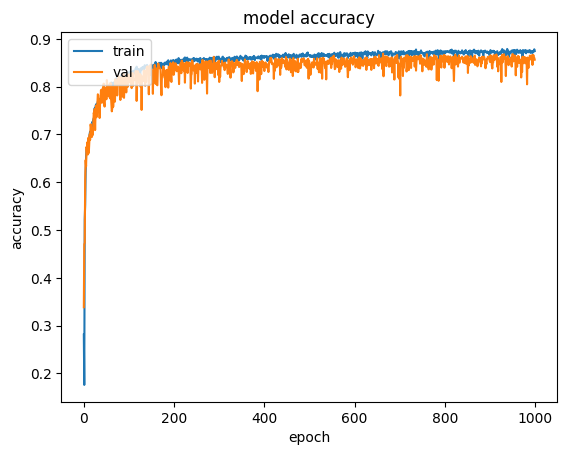

In [48]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [49]:
X_test_inv = scalerX.inverse_transform(X_test+X_min)

In [50]:



load_DT_model= True
if load_DT_model:
  DT_model = keras.models.load_model(tree_model_path)


table = pd.DataFrame(columns=["Input Values", 'elapsedTime%','executorRunTime%','executorCpuTime%','resultSize%','diskBytesSpilled%','memoryBytesSpilled%','peakExecutionMemory%','bytesRead%']  )
for i in range(len(X_test)):
  preds = DT_model.predict(np.array([X_test[i]]))
  preds = scalerY.inverse_transform(preds-X_min)
  test = scalerY.inverse_transform(np.array([y_test[i]])-X_min)

  percentages_diff_temp=[]
  diff = (preds[0]-test[0])/test[0]
  diff = np.around(diff,decimals=4)
  diff = list(diff)
  diff.insert(0,X_test_inv[i])
  table.loc[len(table)] = diff



1/1 [==============================] - 0s 22ms/step


In [51]:
table

,Input Values,elapsedTime%,executorRunTime%,executorCpuTime%,resultSize%,diskBytesSpilled%,memoryBytesSpilled%,peakExecutionMemory%,bytesRead%
0,"[4.0, 4000000.0, 46.0, 33.0]",-0.0407,-0.0417,-0.0415,-0.0212,-0.0088,-0.0163,-0.0208,-0.0224
1,"[2.0, 200000.0, 15.0, 16.0]",0.0146,0.0132,0.0130,-0.0047,0.0073,0.0075,0.0035,0.0037
2,"[3.0, 15000000.0, 42.0, 30.0]",-0.0117,-0.0120,-0.0159,-0.0143,-0.0272,-0.0283,-0.0201,-0.0261
3,"[2.0, 2000000.0000000005, 45.0, 21.0]",-0.0052,-0.0051,-0.0108,-0.0226,-0.0098,-0.0111,-0.0374,-0.0312
4,"[2.0, 2000000.0000000005, 73.0, 45.0]",-0.0112,-0.0076,-0.0090,-0.0259,-0.0013,-0.0020,-0.0091,-0.0108
5,"[4.0, 4000000.0, 45.0, 33.0]",-0.0269,-0.0280,-0.0347,-0.0230,-0.0073,-0.0143,-0.0208,-0.0207
6,"[4.0, 20000000.0, 96.99999999999999, 37.0]",-0.0195,-0.0195,-0.0201,-0.0172,-0.0229,-0.0234,-0.0046,-0.0057
7,"[5.0, 5000000.0, 25.0, 12.0]",0.0742,0.0732,0.0724,-0.0130,0.0070,0.0075,-0.0018,-0.0072
8,"[4.0, 4000000.0, 80.0, 44.0]",-0.0025,-0.0035,-0.0043,-0.0074,-0.0004,-0.0044,-0.0020,-0.0017
9,"[2.0, 2000000.0000000005, 47.0, 26.0]",-0.0184,-0.0171,-0.0187,-0.0207,-0.0048,-0.0049,-0.0307,-0.0288


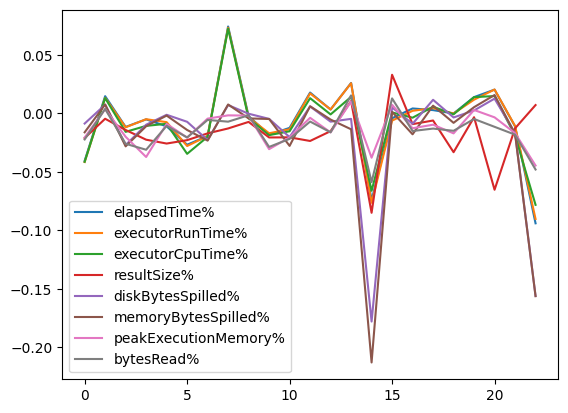

In [52]:
plot = table.plot()

##PCA Prediction

In [54]:
pca_results_directory = 'gdrive/MyDrive/D4c/pca_results'

In [55]:
pca_trials_directory  =pca_results_directory +'/trials'

### Data preprocessing

In [56]:
X,y = decode_trial(pca_trials_directory,
                  output_names =['elapsedTime','executorRunTime','executorCpuTime','resultSize','peakExecutionMemory','bytesRead']
 )

for i in range(len(X)):
  del X[i][4]
scalerX = Scaler()
scalerY = Scaler()
scalerX.fit(X)
scalerY.fit(y)

X = scalerX.transform(X)
y=  scalerY.transform(y)
X_min = X.min()
X = X -X_min
y_min= y.min()
y= y - y_min




###Correlation

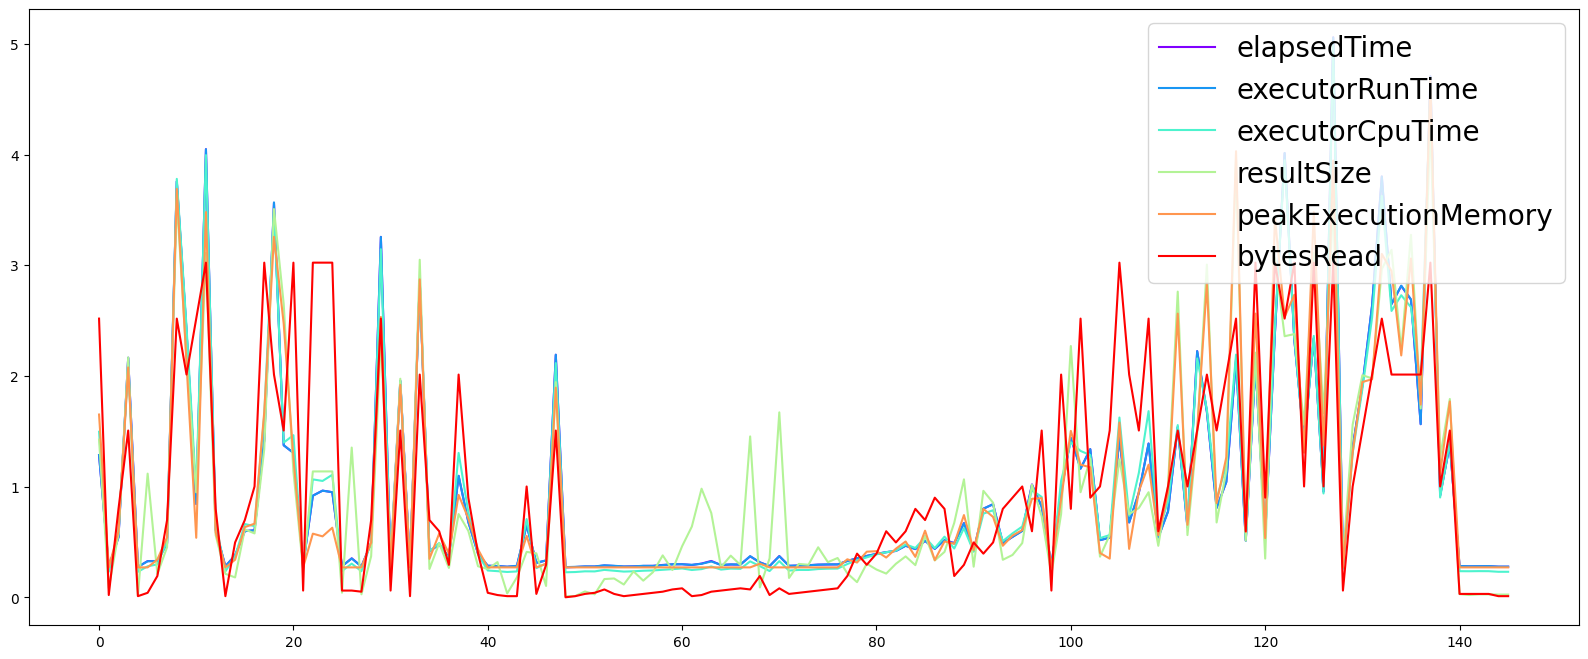

In [57]:
x_select =1
X_names =['number of classes','numbers of rows','numerical data dimensions','categorical data dimensions']
y_names =['elapsedTime','executorRunTime','executorCpuTime','resultSize','peakExecutionMemory','bytesRead']
colors = cm.rainbow(np.linspace(0, 1, len(y_names)))
plt.figure(figsize=(20,8))

for y_select in range(len(y_names)):
  y_0 = [first[y_select] for first in y]
  plt.plot(y_0,c=colors[y_select],label =y_names[y_select])

plt.legend(loc="upper right",prop={'size': 20})

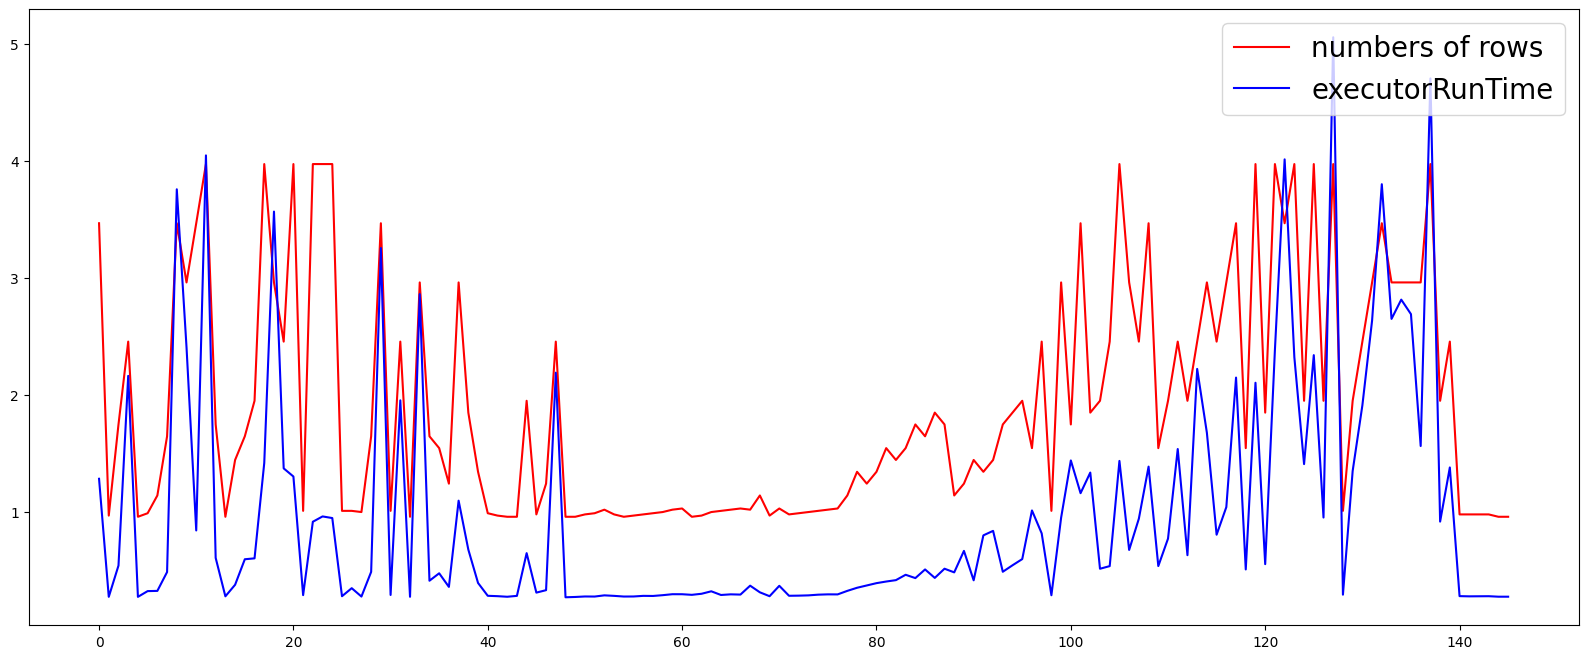

In [58]:
x_select= 1
y_select = 1
X_names =['number of classes','numbers of rows','numerical data dimensions','categorical data dimensions']
y_names =['elapsedTime','executorRunTime','executorCpuTime','resultSize','diskBytesSpilled','memoryBytesSpilled','peakExecutionMemory','bytesRead']

X_size = [x[x_select] for x in X]
plt.figure(figsize=(20,8))
plt.plot(X_size,c='r',label  =X_names[x_select] )
y_0 = [first[y_select] for first in y]
plt.plot(y_0,c='b',label =y_names[y_select])
plt.legend(loc="upper right",prop={'size': 20})

###Neural Network

In [59]:
# Define the neural network pca_model
pca_model = keras.Sequential()

# Input layer with 5 input features
# Output layer with 8 outputs (corresponding to your requirement)
pca_model.add(Dense(8, input_shape=(4,),activation='relu'))  # You can choose an appropriate activation function
pca_model.add(Dense(16 ,activation='relu'))  # You can choose an appropriate activation function
pca_model.add(Dense(32 ,activation='relu'))  # You can choose an appropriate activation function
pca_model.add(Dense(64 ,activation='relu'))  # You can choose an appropriate activation function

pca_model.add(Dense(128 ,activation='relu'))  # You can choose an appropriate activation function
pca_model.add(Dense(64 ,activation='relu'))  # You can choose an appropriate activation function

pca_model.add(Dense(32 ,activation='relu'))  # You can choose an appropriate activation function
pca_model.add(Dense(16 ,activation='relu'))  # You can choose an appropriate activation function

pca_model.add(Dense(6,activation='linear'))  # You can choose an appropriate activation function

# Compile the pca_model
optimizer = keras.optimizers.Adam(learning_rate=0.005)  # Adjust the learning rate
pca_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Display a summary of the pca_model architecture
pca_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 8)                 40        
                                                                 
 dense_8 (Dense)             (None, 16)                144       
                                                                 
 dense_9 (Dense)             (None, 32)                544       
                                                                 
 dense_10 (Dense)            (None, 64)                2112      
                                                                 
 dense_11 (Dense)            (None, 128)               8320      
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dense_13 (Dense)            (None, 32)               

In [60]:

# Assuming you have loaded your data into X (features) and y (target labels)

# Step 1: Split data into training and the rest (validation + testing)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_val,y_train_val = augment_data(X_train_val,y_train_val,new_elements=20000)
# Step 2: Split the remaining data into validation and testing
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Now you have:
# - X_train, y_train: Training data and labels
# - X_val, y_val: Validation data and labels
# - X_test, y_test: Testing data and labels


In [61]:
history = pca_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/1000
252/252 [==============================] - 3s 4ms/step - loss: 0.2734 - accuracy: 0.4137 - val_loss: 0.0561 - val_accuracy: 0.5698
Epoch 2/1000
252/252 [==============================] - 1s 3ms/step - loss: 0.0490 - accuracy: 0.6256 - val_loss: 0.0382 - val_accuracy: 0.7127
Epoch 3/1000
252/252 [==============================] - 1s 3ms/step - loss: 0.0361 - accuracy: 0.6799 - val_loss: 0.0288 - val_accuracy: 0.6864
Epoch 4/1000
252/252 [==============================] - 1s 3ms/step - loss: 0.0272 - accuracy: 0.6961 - val_loss: 0.0272 - val_accuracy: 0.6859
Epoch 5/1000
252/252 [==============================] - 1s 4ms/step - loss: 0.0204 - accuracy: 0.7089 - val_loss: 0.0158 - val_accuracy: 0.7527
Epoch 6/1000
252/252 [==============================] - 1s 5ms/step - loss: 0.0159 - accuracy: 0.7208 - val_loss: 0.0120 - val_accuracy: 0.7587
Epoch 7/1000
252/252 [==============================] - 1s 5ms/step - loss: 0.0120 - accuracy: 0.7300 - val_loss: 0.0140 - val_accuracy:

####Store

In [62]:
model_pca_save =False
pca_model_path ='gdrive/MyDrive/D4c/models/pca_model.keras'
if model_pca_save:
  pca_model.save(pca_model_path)

####Visualize

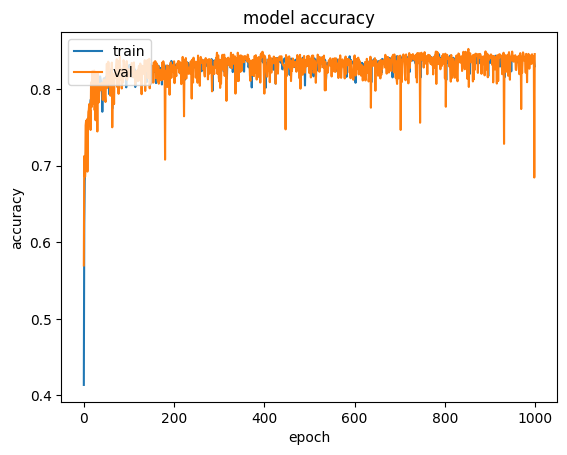

In [63]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [64]:
X_test_inv = scalerX.inverse_transform(X_test+X_min)

In [65]:
percentages_diff = []
max_percentage_diff =0

load_pca_model =True
if load_pca_model:
  pca_model = keras.models.load_model(pca_model_path)
table = pd.DataFrame(columns=["Input Values", 'elapsedTime%','executorRunTime%','executorCpuTime%','resultSize%','peakExecutionMemory%','bytesRead%']  )


for i in range(len(X_test)):
  preds = pca_model.predict(np.array([X_test[i]]))
  preds = scalerY.inverse_transform(preds-X_min)
  test = scalerY.inverse_transform(np.array([y_test[i]])-X_min)

  diff = (preds[0]-test[0])/test[0]
  diff = np.around(diff,decimals=4)
  diff = list(diff)
  diff.insert(0,X_test_inv[i])
  table.loc[len(table)] = diff





1/1 [==============================] - 0s 23ms/step


In [66]:
table

,Input Values,elapsedTime%,executorRunTime%,executorCpuTime%,resultSize%,peakExecutionMemory%,bytesRead%
0,"[4.0, 400000.0, 67.0, 37.0]",0.0187,0.0178,0.0107,0.0126,0.0296,0.0318
1,"[3.0, 15000000.0, 41.0, 31.0]",0.0386,0.0369,0.0344,0.0099,0.0244,0.0158
2,"[6.0, 599999.9999999981, 14.0, 5.0]",0.0125,0.0124,0.0071,-0.0068,0.0225,0.0064
3,"[3.0, 15000000.0, 98.0, 44.0]",0.0722,0.0686,0.0569,0.0646,0.0652,0.0188
4,"[2.0, 200000.0, 17.000000000000004, 14.0]",0.0084,0.0077,0.0036,0.0017,0.0206,-0.0053
5,"[9.0, 9000000.0, 31.0, 27.0]",0.0332,0.0318,0.0257,0.0308,0.0380,0.0119
6,"[5.0, 24999999.999999996, 58.0, 53.0]",0.0121,0.0092,0.0156,0.0422,0.0676,0.0378
7,"[4.0, 4000000.0, 34.0, 31.0]",-0.0064,-0.0073,-0.0302,-0.0041,-0.0149,-0.0629
8,"[9.0, 899999.9999999981, 36.0, 18.0]",0.0168,0.0167,0.0096,-0.0142,0.0252,0.0087
9,"[4.0, 20000000.0, 96.0, 48.0]",0.0930,0.0891,0.0776,0.0492,0.0611,0.0189


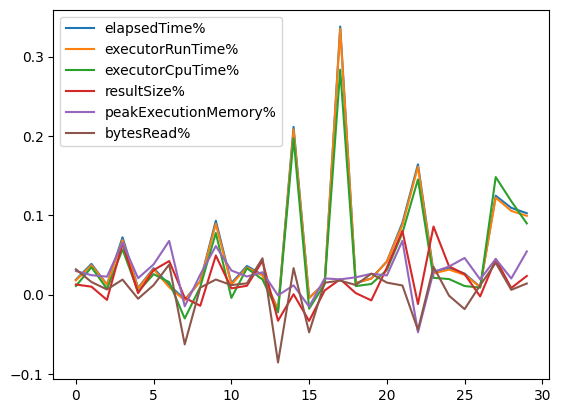

In [67]:
plot = table.plot()

##FP Prediction

In [108]:
fp_growth_results_directory  = 'gdrive/MyDrive/D4c/FP_Growth/fp_growth_results'

In [109]:
fp_growth_trials_directory  =fp_growth_results_directory +'/trials'

###FP Decode Trial

In [110]:
def extract_numbers(text):
    numbers = re.findall(r'\b\d+\.\d+|\b\d+\b', text)
    return numbers


In [111]:
def fp_decode_trial(folder,
                output_names =['elapsedTime','executorRunTime','executorCpuTime','resultSize','diskBytesSpilled','memoryBytesSpilled','peakExecutionMemory','bytesRead']
):
  X =[]
  y =[]
  for trial_file in os.listdir(folder):
    file = open(folder+'/'+trial_file,mode='r')
    trials = file.read()
    trials = trials.split('&')[1:]
    for trial in trials:
      lines = trial.split('\n')
      inputs=  []
      outputs = []

      for line in lines:
        if len(line)>0:
          if line[0] =='#':
            orismata = line.split('#')
            for i in orismata:
              j = extract_numbers(i)
              if j != []:
                j=j[0]
                inputs.append(float(j))

          for name in output_names:
            if line[:len(name)] ==name:
              value = line.split(' ')[2]
              outputs.append(float(value))
      X.append(inputs)
      y.append(outputs)
  return X,y

### Data preprocessing

In [112]:
X,y = fp_decode_trial(fp_growth_trials_directory,
                  output_names =['elapsedTime','executorRunTime','executorCpuTime','resultSize','peakExecutionMemory','bytesRead']
 )

for i in range(len(X)):
  del X[i][3]

for i in range(len(X)):
  del X[i][2]
scalerX = Scaler()
scalerY = Scaler()
scalerX.fit(X)
scalerY.fit(y)

X = scalerX.transform(X)
y=  scalerY.transform(y)
X_min = X.min()
X = X -X_min
y_min= y.min()
y= y - y_min




###Correlation

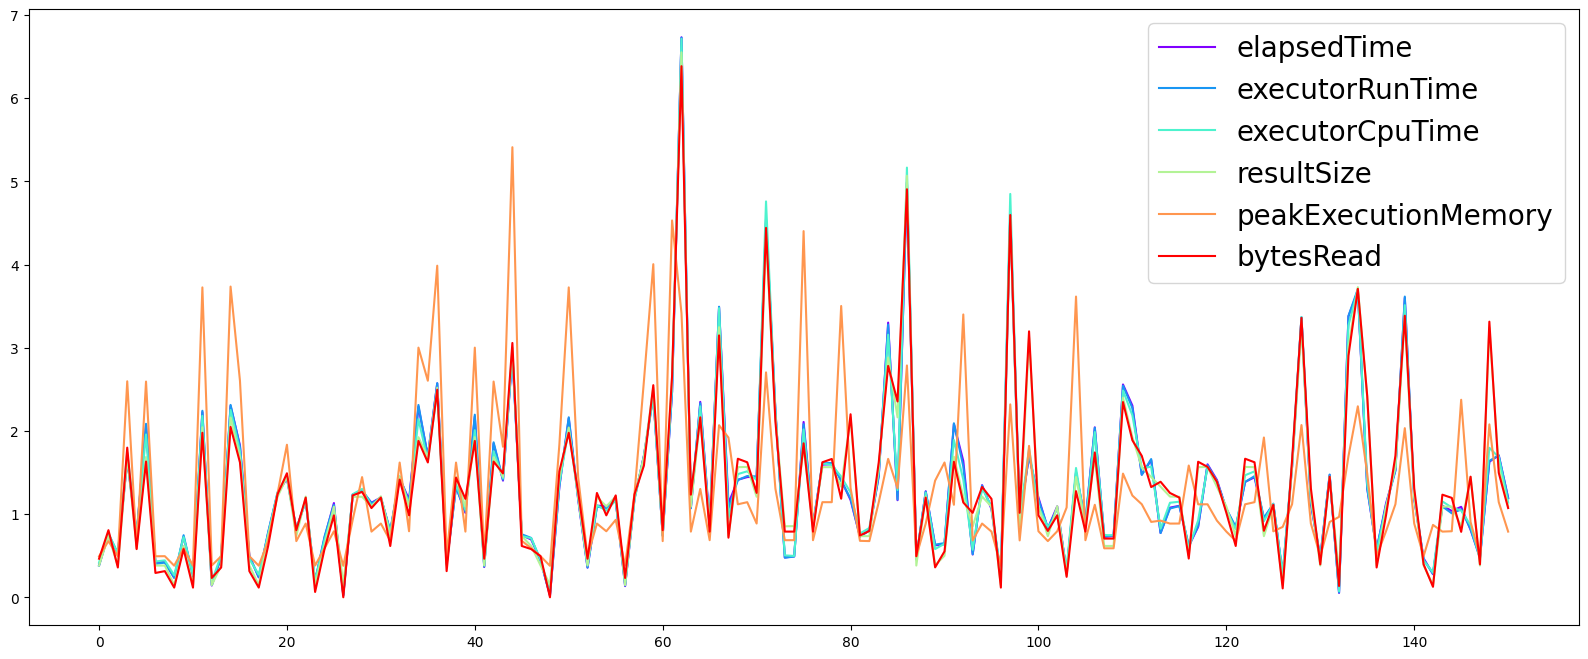

In [113]:
x_select =1
X_names =['number of classes','numbers of rows','numerical data dimensions','categorical data dimensions']
y_names =['elapsedTime','executorRunTime','executorCpuTime','resultSize','peakExecutionMemory','bytesRead']
colors = cm.rainbow(np.linspace(0, 1, len(y_names)))
plt.figure(figsize=(20,8))

for y_select in range(len(y_names)):
  y_0 = [first[y_select] for first in y]
  plt.plot(y_0,c=colors[y_select],label =y_names[y_select])

plt.legend(loc="upper right",prop={'size': 20})

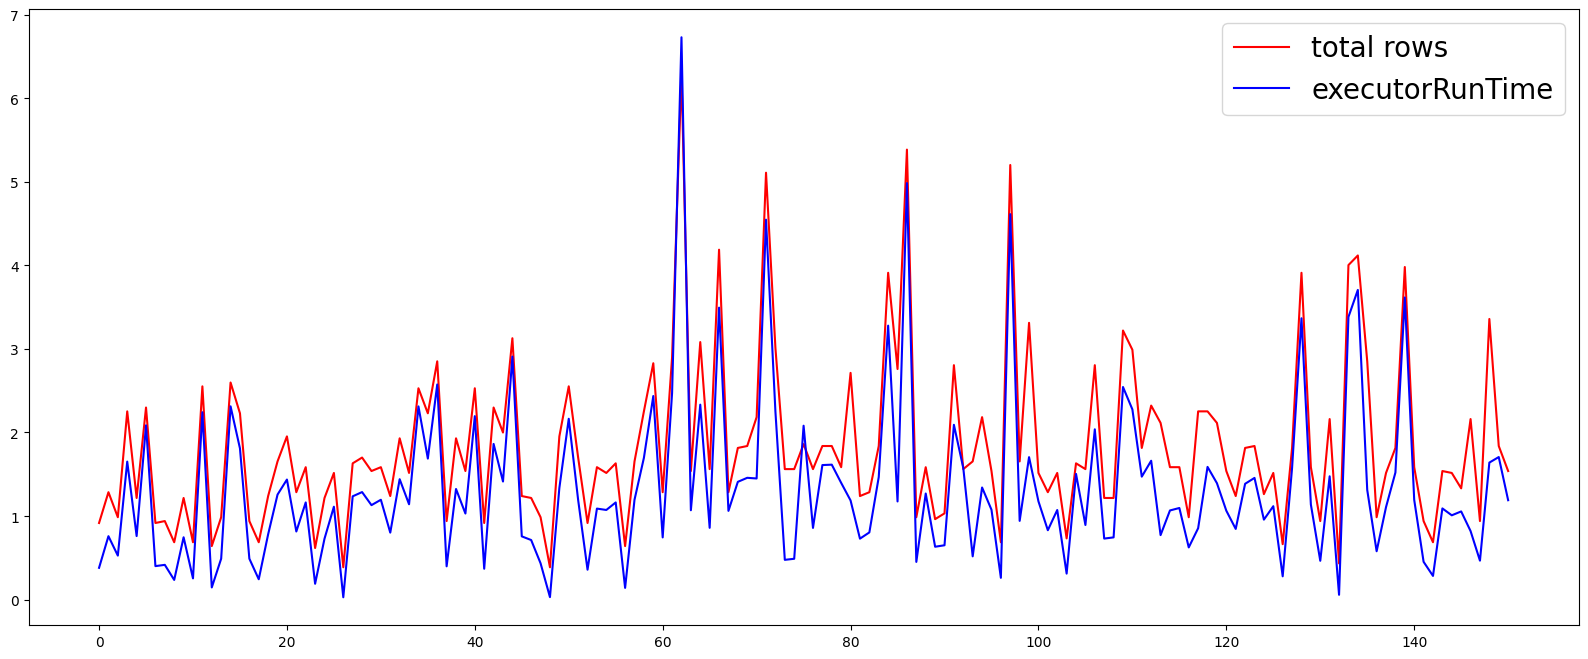

In [114]:
x_select= 0
y_select = 1
X_names =['total rows ','mean item per list']
y_names =['elapsedTime','executorRunTime','executorCpuTime','resultSize','diskBytesSpilled','memoryBytesSpilled','peakExecutionMemory','bytesRead']

X_size = [x[x_select] for x in X]
plt.figure(figsize=(20,8))
plt.plot(X_size,c='r',label  =X_names[x_select] )
y_0 = [first[y_select] for first in y]
plt.plot(y_0,c='b',label =y_names[y_select])
plt.legend(loc="upper right",prop={'size': 20})

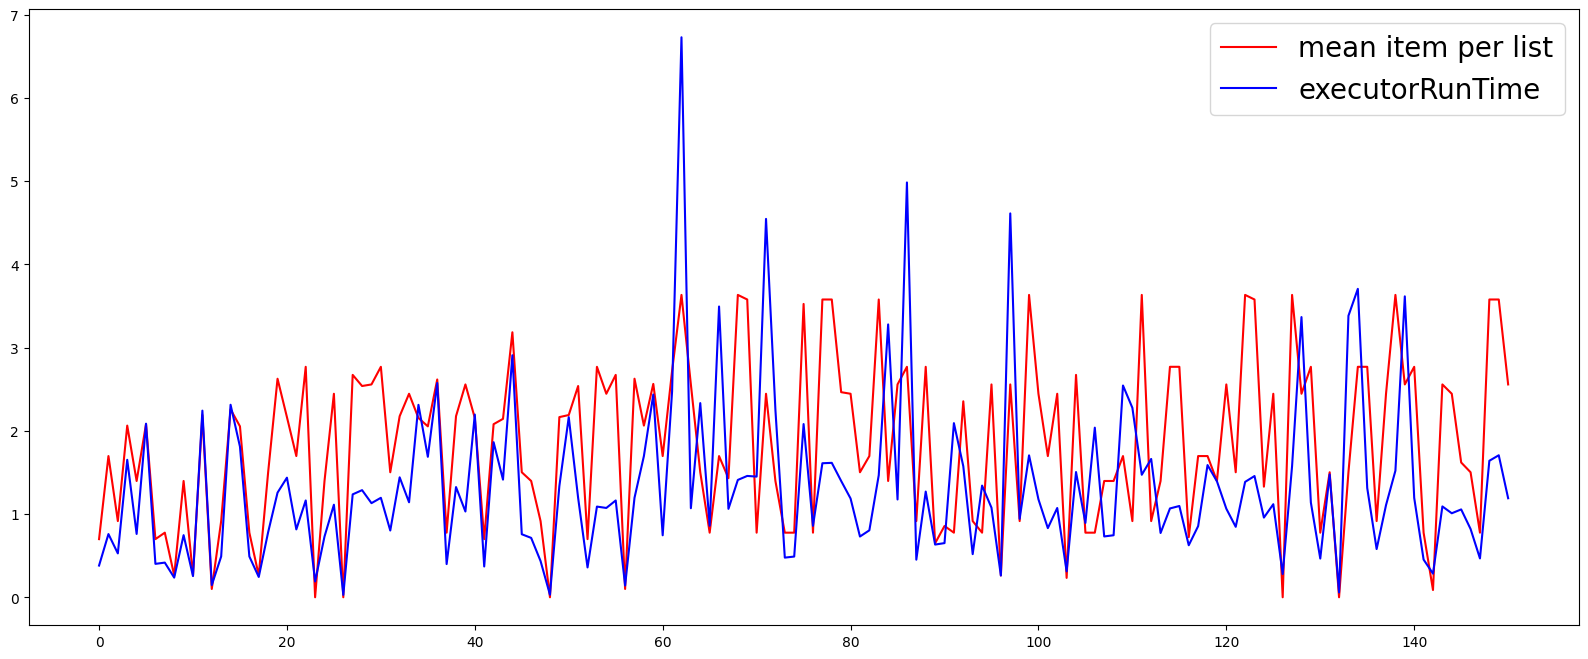

In [115]:
x_select= 1
y_select = 1
X_names =['total rows ','mean item per list']
y_names =['elapsedTime','executorRunTime','executorCpuTime','resultSize','diskBytesSpilled','memoryBytesSpilled','peakExecutionMemory','bytesRead']

X_size = [x[x_select] for x in X]
plt.figure(figsize=(20,8))
plt.plot(X_size,c='r',label  =X_names[x_select] )
y_0 = [first[y_select] for first in y]
plt.plot(y_0,c='b',label =y_names[y_select])
plt.legend(loc="upper right",prop={'size': 20})

###Neural Network

In [116]:
# Define the neural network fp_model
fp_model = keras.Sequential()

# Input layer with 5 input features
# Output layer with 8 outputs (corresponding to your requirement)
fp_model.add(Dense(8, input_shape=(2,),activation='relu'))  # You can choose an appropriate activation function
fp_model.add(Dense(16 ,activation='relu'))  # You can choose an appropriate activation function
fp_model.add(Dense(32 ,activation='relu'))  # You can choose an appropriate activation function
fp_model.add(Dense(32 ,activation='relu'))  # You can choose an appropriate activation function
fp_model.add(Dense(16 ,activation='relu'))  # You can choose an appropriate activation function
fp_model.add(Dense(6,activation='linear'))  # You can choose an appropriate activation function

# Compile the fp_model
optimizer = keras.optimizers.Adam(learning_rate=0.005)  # Adjust the learning rate
fp_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Display a summary of the fp_model architecture
fp_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 8)                 24        
                                                                 
 dense_23 (Dense)            (None, 16)                144       
                                                                 
 dense_24 (Dense)            (None, 32)                544       
                                                                 
 dense_25 (Dense)            (None, 32)                1056      
                                                                 
 dense_26 (Dense)            (None, 16)                528       
                                                                 
 dense_27 (Dense)            (None, 6)                 102       
                                                                 
Total params: 2398 (9.37 KB)
Trainable params: 2398 (9

In [117]:

# Assuming you have loaded your data into X (features) and y (target labels)

# Step 1: Split data into training and the rest (validation + testing)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_val,y_train_val = augment_data(X_train_val,y_train_val,new_elements=20000)
# Step 2: Split the remaining data into validation and testing
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Now you have:
# - X_train, y_train: Training data and labels
# - X_val, y_val: Validation data and labels
# - X_test, y_test: Testing data and labels


In [118]:
history = fp_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/1000
252/252 [==============================] - 3s 4ms/step - loss: 0.6089 - accuracy: 0.1832 - val_loss: 0.1749 - val_accuracy: 0.3188
Epoch 2/1000
252/252 [==============================] - 1s 3ms/step - loss: 0.1566 - accuracy: 0.3593 - val_loss: 0.1477 - val_accuracy: 0.3723
Epoch 3/1000
252/252 [==============================] - 1s 3ms/step - loss: 0.1378 - accuracy: 0.4215 - val_loss: 0.1343 - val_accuracy: 0.4267
Epoch 4/1000
252/252 [==============================] - 1s 3ms/step - loss: 0.1290 - accuracy: 0.4431 - val_loss: 0.1274 - val_accuracy: 0.4965
Epoch 5/1000
252/252 [==============================] - 1s 3ms/step - loss: 0.1228 - accuracy: 0.4678 - val_loss: 0.1263 - val_accuracy: 0.4968
Epoch 6/1000
252/252 [==============================] - 1s 3ms/step - loss: 0.1202 - accuracy: 0.5029 - val_loss: 0.1224 - val_accuracy: 0.4893
Epoch 7/1000
252/252 [==============================] - 1s 3ms/step - loss: 0.1190 - accuracy: 0.5172 - val_loss: 0.1194 - val_accuracy:

####Store

In [119]:
model_fp_save =False
fp_model_path ='gdrive/MyDrive/D4c/models/fp_model.keras'
if model_fp_save:
  fp_model.save(fp_model_path)

####Visualize

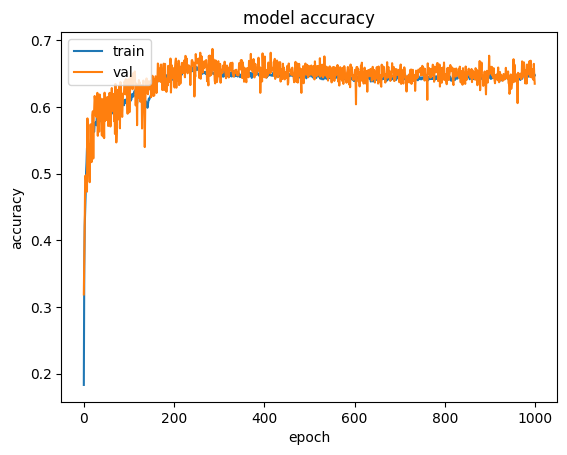

In [120]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [121]:
X_test_inv = scalerX.inverse_transform(X_test+X_min)

In [122]:
percentages_diff = []
max_percentage_diff =0

load_fp_model =True
if load_fp_model:
  fp_model = keras.models.load_model(fp_model_path)
table = pd.DataFrame(columns=["Input Values", 'elapsedTime%','executorRunTime%','executorCpuTime%','resultSize%','peakExecutionMemory%','bytesRead%']  )


for i in range(len(X_test)):
  preds = fp_model.predict(np.array([X_test[i]]))
  preds = scalerY.inverse_transform(preds-X_min)
  test = scalerY.inverse_transform(np.array([y_test[i]])-X_min)

  diff = (preds[0]-test[0])/test[0]
  diff = np.around(diff,decimals=4)
  diff = list(diff)
  diff.insert(0,X_test_inv[i])
  table.loc[len(table)] = diff





1/1 [==============================] - 0s 26ms/step


In [123]:
table

,Input Values,elapsedTime%,executorRunTime%,executorCpuTime%,resultSize%,peakExecutionMemory%,bytesRead%
0,"[27000000.000000004, 6.388888888888889]",-0.0206,-0.0169,-0.0196,0.0107,0.0113,0.0084
1,"[20000000.0, 7.6875]",0.0022,-0.0001,0.0084,-0.0131,-0.0183,0.0115
2,"[21000000.0, 8.035714285714286]",0.0024,0.0027,0.0035,0.0096,0.0052,0.0105
3,"[20000000.0, 7.6875]",0.0123,0.0132,0.0042,-0.0131,-0.0183,-0.0203
4,"[26500000.000000004, 9.575471698113208]",0.0117,0.0095,-0.0106,0.0113,0.0102,-0.0355
5,"[20000000.0, 7.6875]",-0.0019,-0.0051,0.0009,-0.0131,-0.0183,0.0115
6,"[33000000.0, 11.401515151515152]",-0.0033,-0.0052,0.0046,0.0140,0.0203,0.0064
7,"[60000000.0, 7.6875]",-0.0002,0.0028,0.0019,0.0184,0.0071,0.0090
8,"[28500000.0, 9.780701754385966]",-0.0048,-0.0069,0.0012,-0.0047,0.0408,-0.0047
9,"[53000000.0, 9.575471698113208]",0.0130,0.0139,0.0058,0.0086,-0.0039,-0.0135


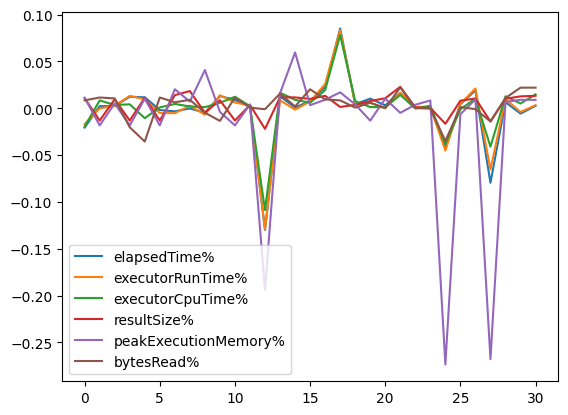

In [124]:
plot = table.plot()